home_power projet:
This notebook processes a table export from Power BI for Production and Radiation data with synchronized timestamps (by Power Query M language).
Purpose is to determine regression functions and check drift Year On Year of the power production capacity of the solar panels

In [546]:
%config IPCompleter.greedy=True

In [547]:
%run init_notebook.py

In [548]:
%%time
import pandas as pd
import os

# lecture des données.
# low_memory False car on veut que le type de chaque colonne prenne en compte l'ensemble des lignes
# df = pd.read_csv(base_raw+"data2022.csv", low_memory=False)

# prepare to open file in F:\projPerso\home_power\data\exportFromPBI
path = r'F:\projPerso\home_power\data\exportFromPBI'
filename = 'completeSunnyHours2024_2025.csv'
data_file = os.path.join(path, filename)
if not os.path.exists(data_file):
    print(f"Data file {data_file} not found.")
    sys.exit(1)
df = pd.read_csv(data_file)
print("Data loaded successfully.")

Data loaded successfully.
CPU times: total: 31.2 ms
Wall time: 6.07 ms


In [549]:
# affichage des caractéristiques principales de nos données

display(df.head())
print("\n***********************\n")
display(df.info())


,DateHourKey,Hour,Radiation,Production (Wh)
0,2024-07-27-11,11:00,175.90356,0
1,2024-07-27-12,12:00,237.37251,0
2,2024-07-27-13,13:00,179.05959,0
3,2024-07-27-14,14:00,278.74426,0
4,2024-07-27-15,15:00,245.13994,0



***********************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateHourKey      3017 non-null   object 
 1   Hour             3017 non-null   object 
 2   Radiation        3017 non-null   float64
 3   Production (Wh)  3017 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 94.4+ KB


None

In [550]:
# Extract the date part from 'DateHourKey' and create a new 'Date' column
df['Date'] = df['DateHourKey'].str.slice(0, 10)

# Optional: convert to datetime format if needed
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df.rename(columns={'Hour': 'Time'}, inplace=True)
df.rename(columns={'Production (Wh)': 'Production'}, inplace=True)
df.drop(columns=['DateHourKey'], inplace=True)


display(df.head())
print("\n***********************\n")
display(df.info())

,Time,Radiation,Production,Date
0,11:00,175.90356,0,2024-07-27
1,12:00,237.37251,0,2024-07-27
2,13:00,179.05959,0,2024-07-27
3,14:00,278.74426,0,2024-07-27
4,15:00,245.13994,0,2024-07-27



***********************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time        3017 non-null   object        
 1   Radiation   3017 non-null   float64       
 2   Production  3017 non-null   int64         
 3   Date        3017 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 94.4+ KB


None

In [551]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Description statistique des colonnes numériques
print("Description statistique des colonnes numériques :")
display(df.describe())

print("\n***********************\n")

# Vérification des valeurs nulles
print("Nombre de valeurs nulles par colonne :")
display(df.isnull().sum())

print("\n***********************\n")

# Types de données de chaque colonne
print("Types de données de chaque colonne :")
display(df.dtypes)

print("\n***********************\n")

# Nombre de valeurs uniques par colonne
print("Nombre de valeurs uniques par colonne :")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

print("\n********** fini *************\n")


Description statistique des colonnes numériques :


,Radiation,Production,Date
count,3017.000000,3017.000000,3017
mean,401.308895,123.702353,2025-02-27 00:00:00
min,3.594559,0.000000,2024-07-27 00:00:00
25%,179.059590,36.000000,2024-11-11 00:00:00
50%,373.355400,103.000000,2025-02-27 00:00:00
75%,610.540470,208.000000,2025-06-15 00:00:00
max,930.559750,319.000000,2025-09-30 00:00:00
std,252.422091,95.100716,NaN



***********************

Nombre de valeurs nulles par colonne :


Time          0
Radiation     0
Production    0
Date          0
dtype: int64


***********************

Types de données de chaque colonne :


Time                  object
Radiation            float64
Production             int64
Date          datetime64[ns]
dtype: object


***********************

Nombre de valeurs uniques par colonne :
Time: 7 unique values
Radiation: 3006 unique values
Production: 315 unique values
Date: 431 unique values

********** fini *************

CPU times: total: 78.1 ms
Wall time: 40.7 ms


In [552]:
%%time
# le tableau est lourd, on va supprimer les colonnes contenant seulement des Nan ou bien 1 seule valeur
# Suppression des colonnes contenant seulement des NaN
df_cleaned = df.dropna(axis=1, how='all')
print("Colonnes restantes après nettoyage des colonnes vides :")
display(df_cleaned.info())
# Suppression des colonnes ayant une seule valeur unique
for col in df_cleaned.columns:
    if df_cleaned[col].nunique() <= 1:
        df_cleaned = df_cleaned.drop(columns=[col])

# Affichage des informations sur le nouveau dataframe allégé
print("\nColonnes restantes après nettoyage des colonnes mono-modales :")
display(df_cleaned.info())


Colonnes restantes après nettoyage des colonnes vides :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time        3017 non-null   object        
 1   Radiation   3017 non-null   float64       
 2   Production  3017 non-null   int64         
 3   Date        3017 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 94.4+ KB


None


Colonnes restantes après nettoyage des colonnes mono-modales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time        3017 non-null   object        
 1   Radiation   3017 non-null   float64       
 2   Production  3017 non-null   int64         
 3   Date        3017 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 94.4+ KB


None

CPU times: total: 31.2 ms
Wall time: 30.3 ms


In [553]:
# we drop rows were Production is null or Radiation is null
df_cleaned = df_cleaned.dropna(subset=['Production', 'Radiation'])
# we drop rows were Production is 0 or Radiation is 0
df_cleaned = df_cleaned[(df_cleaned['Production'] != 0) & (df_cleaned['Radiation'] != 0)]
df_cleaned.head

<bound method NDFrame.head of        Time  Radiation  Production       Date
6     17:00  406.45710          59 2024-07-27
7     11:00  715.28990         237 2024-07-28
8     12:00  780.86334         285 2024-07-28
9     13:00  870.98180         310 2024-07-28
10    14:00  873.09130         319 2024-07-28
...     ...        ...         ...        ...
3012  13:00  520.78140         225 2025-09-30
3013  14:00  457.53036         206 2025-09-30
3014  15:00  443.08140         169 2025-09-30
3015  16:00  361.53354         117 2025-09-30
3016  17:00  271.51715          25 2025-09-30

[2982 rows x 4 columns]>


********** sample (100%) *************

<class 'pandas.core.frame.DataFrame'>
Index: 2982 entries, 2328 to 2018
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time        2982 non-null   object        
 1   Radiation   2982 non-null   float64       
 2   Production  2982 non-null   int64         
 3   Date        2982 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 116.5+ KB


None

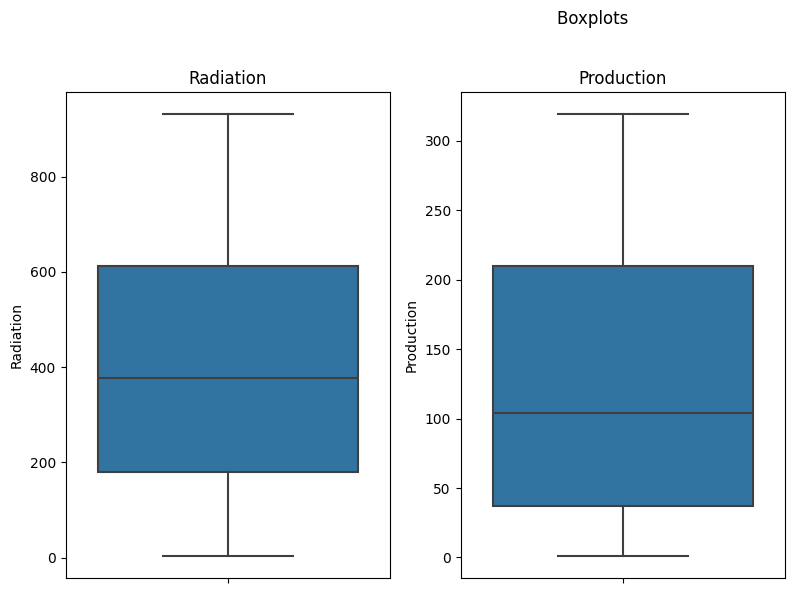

c:\Users\local\anaconda\envs\DST\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\local\anaconda\envs\DST\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


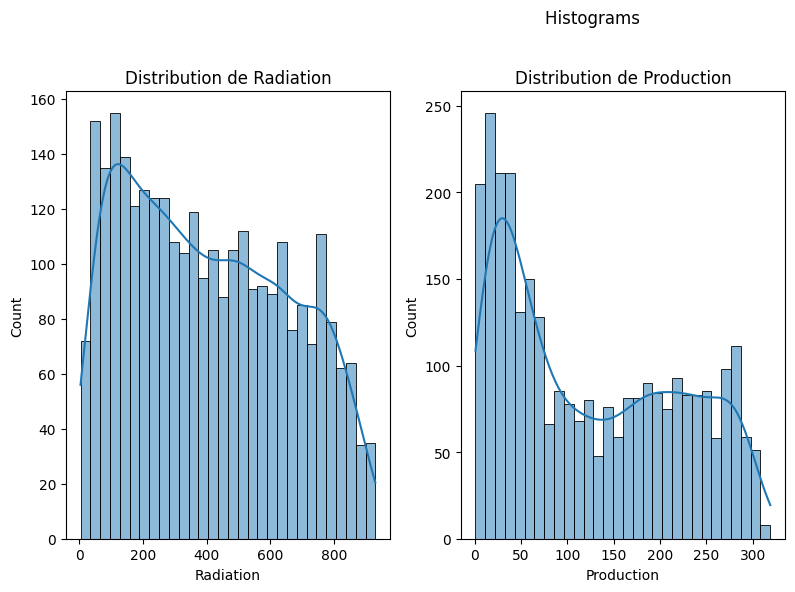

fini


In [554]:

# Visualisation de la distribution des données numériques
# pour trop de données, pour mettre au point le python, on doit échantillonner
pourcentage=1    # avec par exemple 0.01 = 1%
print(f"\n********** sample ({pourcentage*100}%) *************\n")
sample_df = df_cleaned.sample(frac=pourcentage)  # Prend un échantillon de quelques % des données
display(sample_df.info())

numeric_cols = sample_df.select_dtypes(include=['float64', 'int64']).columns
subset_df= sample_df

    
# Obtenir le nombre de lignes
num_rows = subset_df.shape[0]

# Create a boxplot for each numeric column
plt.figure(figsize=(12, 6))
plt.suptitle(f'Boxplots ')
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
    if subset_df[col].nunique() > 1:  # Ensure there are more than 1 unique value for boxplot
        sns.boxplot(data=subset_df, y=col)
    plt.title(col)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a histogram for each numeric column
plt.figure(figsize=(12, 6))
plt.suptitle(f'Histograms ')
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
    sns.histplot(data=subset_df, x=col, bins=30, kde=True)
    plt.title(f'Distribution de {col}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("fini")


In [555]:
# Sauvegarder le DataFrame df_temp dans un fichier CSV. à ne pas faire à chaque fois :)
filename = 'python_data_frame.csv'
data_file = os.path.join(path, filename)
df_cleaned.to_csv(data_file, index=False)

avec ce fichier, on pourra charger un dataframe pour explorer les relations entre les paramètres et l'émission de CO2.
Ainsi en effet, un modèle précis de véhicule ayant toujours les memes caractéristiques, inutile de le prendre en compte des milliers de fois par l'analyse des variables explicatives. Et meme je pense, cela biaiserait les résultats (on overfitterait les modèles sur les voitures les + vendues)


***

Ci dessous, pour commencer avec le fichier nettoyé.
***


In [556]:
import pandas as pd

filename = 'python_data_frame.csv'
data_file = os.path.join(path, filename)
df=pd.read_csv(data_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        2982 non-null   object 
 1   Radiation   2982 non-null   float64
 2   Production  2982 non-null   int64  
 3   Date        2982 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 93.3+ KB


In [557]:
# we'll keep only lines where Radiation and production are considered not being impacted by weather effects 
min_radiation=600
min_production=150
df = df[(df['Radiation'] > min_radiation) & (df['Production'] > min_production)]


year_y_minus_1 = '2024' # the Y-1 year to use for comparison
year_y = '2025'         # the Y year to use for comparison

# We restrict the range to get better predictability
select_min_time = 13    # the start time of considerered hours
select_max_time = 18    # the end time of considerered hours

month_to_compare = '08'  # 08=August

minimum_number_of_points=10 # we only plot months with at least this many points

In [558]:
# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# We keep only lines where Radiation and production are considered not being impacted by weather effects
df = df[(df['Radiation'] > min_radiation) & (df['Production'] > min_production)]


In [559]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# define features and target variable
X = df[['Radiation']]
y = df['Production']


# split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a linear regression model
model = LinearRegression()
# fit the model to the training data
model.fit(X_train, y_train)
# make predictions on the test data
y_pred = model.predict(X_test)


# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 736.4448834530901
R^2 Score: 0.48146860982906525


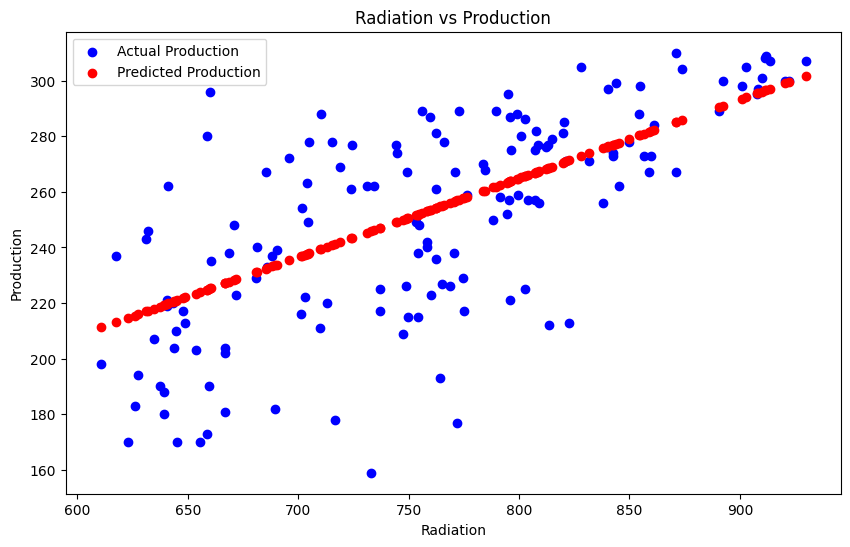

<Figure size 1000x600 with 0 Axes>

Coefficient: 0.2832737272024368
Intercept: 38.23571223046963


In [560]:
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Production')
plt.scatter(X_test, y_pred, color='red', label='Predicted Production')
plt.xlabel('Radiation')
plt.ylabel('Production')
plt.title('Radiation vs Production')
plt.legend()
plt.show()
# plot regression line
plt.figure(figsize=(10, 6))

plt.show()
# print model coefficients
print(f"Coefficient: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

In [561]:
#I spot some outliers, let's consider that 57 Wh / hour divergence from prediction is acceptable, the rest is supposed to be because of local weather effects on either panels or weather forecast sensors.
# Calculate the absolute error
df['Predicted_Production'] = model.predict(df[['Radiation']])

df['Error'] = abs(df['Predicted_Production'] - df['Production'])

# Filter rows where error is beyond acceptable
df_outliers = df[df['Error'] > 57]
print(f"Number of outlier rows: {len(df_outliers)}")
display(df_outliers.head())

# delete outlier rows
df = df[df['Error'] <= 57]


Number of outlier rows: 41


,Time,Radiation,Production,Date,Predicted_Production,Error
24,13:00,706.41050,178,2024-07-31,238.343248,60.343248
33,15:00,623.25116,287,2024-08-01,214.786391,72.213609
38,13:00,750.30720,189,2024-08-02,250.778029,61.778029
51,12:00,636.64640,295,2024-08-04,218.580911,76.419089
54,15:00,696.88520,306,2024-08-04,235.644980,70.355020


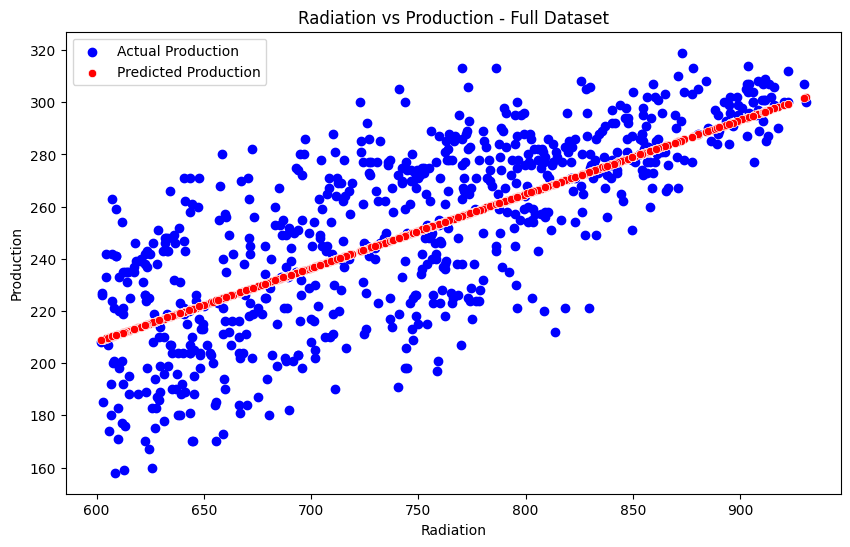

In [562]:
# show the predicted vs actual values for the whole dataset
X= df[['Radiation']]
y= df['Production']


plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Production')
y_full_pred = model.predict(X)
sns.scatterplot(x=X.squeeze(), y=y_full_pred, color='red', label='Predicted Production')
plt.xlabel('Radiation')
plt.ylabel('Production')
plt.title('Radiation vs Production - Full Dataset')
plt.legend()
plt.show()


***
Avec les valeurs de 11 à 17h, on est très disparate, et un calcul de régression ne fait pas sens.
On va afficher mois par mois de voir quels sont les coefficients et intercept

Puis on essaiera de faire un graph+calcul en sélectionnant certaines heures

In [563]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# On scrute mois par mois pour voir quels sont les coefficients et intercept
# We train a linear regression model for each YYYY-MM


def compute_monthly_regression(df, year):
    results = []
    for month in range(1, 13):
        month_str = f"{year}-{month:02d}"
        df_month = df[df['Date'].dt.strftime('%Y-%m') == month_str]
        if len(df_month) < 10:
            continue
        X_month = df_month[['Radiation']]
        y_month = df_month['Production']
        X_train, X_test, y_train, y_test = train_test_split(X_month, y_month, test_size=0.2, random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'Month': month_str,
            'Coefficient': model.coef_[0],
            'Intercept': model.intercept_,
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        })
    return pd.DataFrame(results)

In [564]:
# Ensure Date column is datetime
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Compute results
results_df_y_minus_1 = compute_monthly_regression(df, year_y_minus_1)
results_df_y = compute_monthly_regression(df, year_y)

# Display
print(f"Regression results by month for {year_y_minus_1}:")
display(results_df_y_minus_1)

print(f"Regression results by month for {year_y}:")
display(results_df_y)

Regression results by month for 2024:


,Month,Coefficient,Intercept,MSE,R2
0,2024-07,0.401436,-48.599627,811.113410,-0.553299
1,2024-08,0.433164,-62.340632,408.996806,0.443563
2,2024-09,0.491310,-87.019909,976.355880,-1.309876


Regression results by month for 2025:


,Month,Coefficient,Intercept,MSE,R2
0,2025-03,0.389755,-20.493334,550.275850,0.274494
1,2025-04,0.403109,-49.481983,494.806196,0.644682
2,2025-05,0.275356,48.324888,387.204674,0.617357
3,2025-06,0.239840,75.111538,565.059171,0.580588
4,2025-07,0.304623,21.350422,447.411929,0.549699
5,2025-08,0.373871,-38.193572,488.538222,0.606661
6,2025-09,0.215752,90.843821,267.300564,0.118547


In [565]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def plot_monthly_regressions(df, year, minimum_points=10):
    plt.figure(figsize=(10, 10))
    for month in range(1, 13):
        month_str = f"{year}-{month:02d}"
        df_month = df[df['Date'].dt.strftime('%Y-%m') == month_str]
        if len(df_month) < minimum_points:
            continue
        X = df_month[['Radiation']]
        y = df_month['Production']
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        plt.subplot(4, 3, month)
        plt.scatter(X, y, color='blue', label='Actual Production')
        plt.plot(X, y_pred, color='red', label='Regression Line')
        plt.title(f'Month: {month_str}')
        plt.xlabel('Radiation')
        plt.ylabel('Production')
        plt.legend()

    plt.tight_layout()
    plt.show()

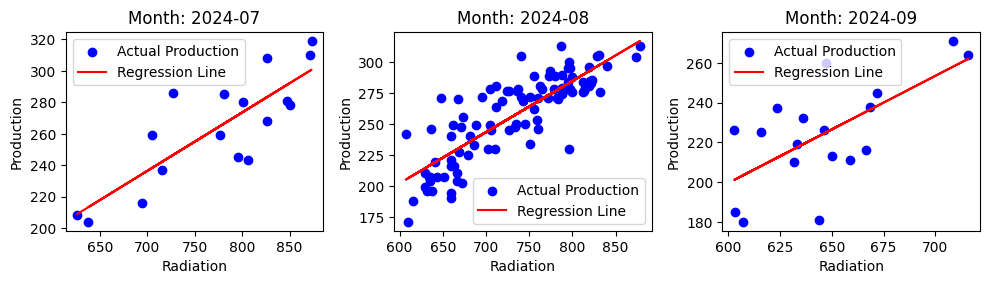

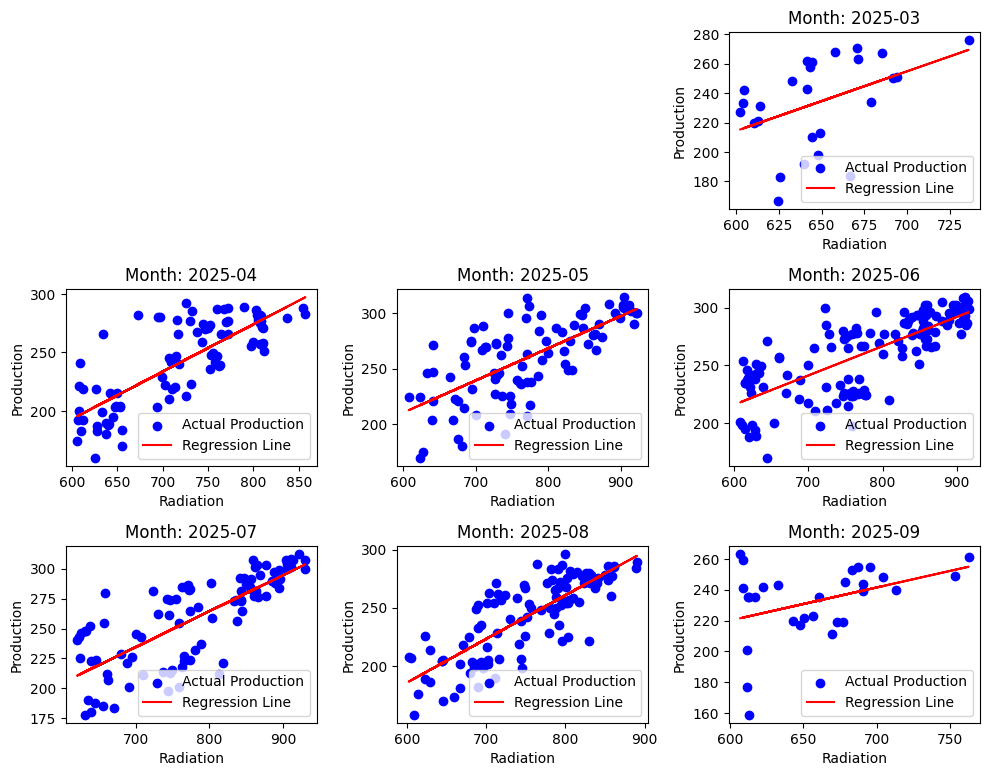

In [566]:
plot_monthly_regressions(df, year_y_minus_1, minimum_number_of_points)
plot_monthly_regressions(df, year_y, minimum_number_of_points)

This is not conclusive, as the intercept is different from graph to graph.
Let's focus on a given month (where we have enough points for both years), select given hours and compare the years.

0    13:00
1    14:00
2    15:00
3    16:00
4    17:00
dtype: object

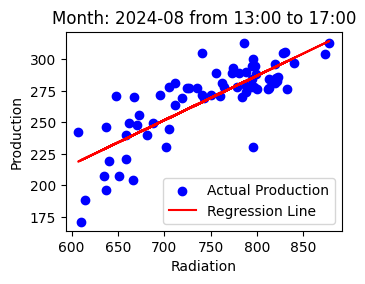

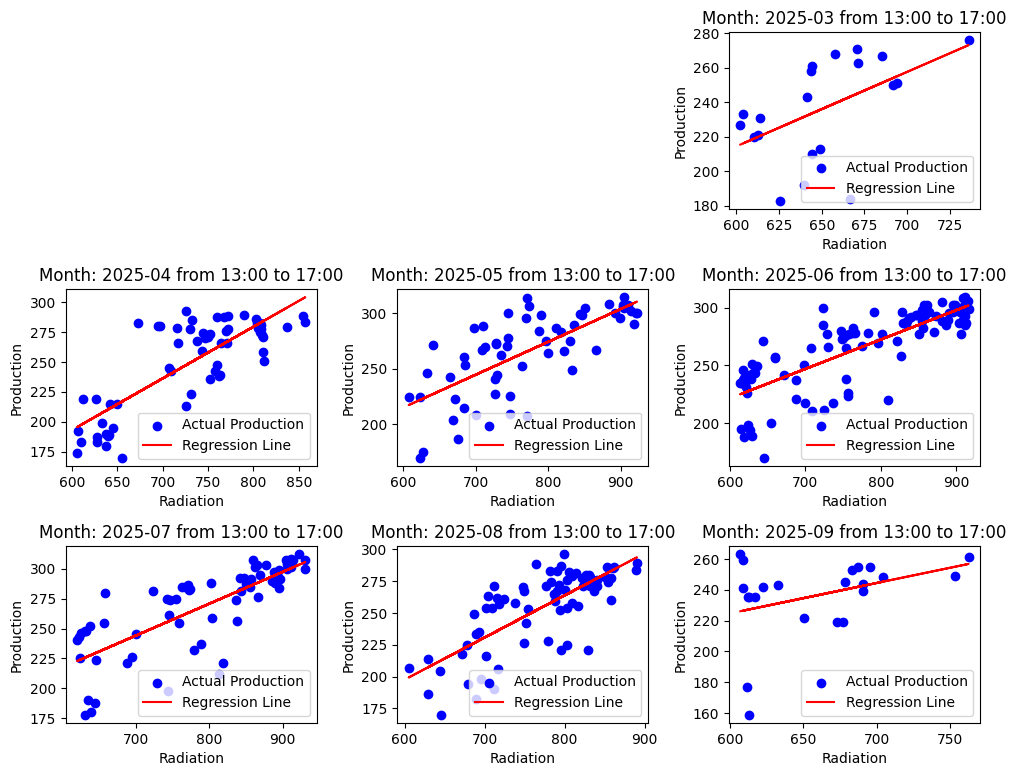

In [567]:
# plot regression line and all data points but only for a selected time, one graph per month.

# Create a Series of time strings like '14:00', '15:00', ...
time_range = pd.Series([f"{hour:02d}:00" for hour in range(select_min_time, select_max_time)])
display(time_range)

if select_max_time - select_min_time == 1:
    time_description = f"at {select_min_time:02d}:00"
else:
    time_description = f"from {select_min_time:02d}:00 to {select_max_time - 1:02d}:00"


# first for Y-1
plt.figure(figsize=(10, 10)) 
for month in range(1, 13):
    month_str = f"{year_y_minus_1}-{month:02d}"

    df_month = df[
        (df['Date'].dt.strftime('%Y-%m') == month_str) &
        (df['Time'].isin(time_range))
    ]

    if len(df_month) < 15:
        continue
    X_month = df_month[['Radiation']]
    y_month = df_month['Production']
    model_m = LinearRegression()
    model_m.fit(X_month, y_month)
    plt.subplot(4, 3, month)
    plt.scatter(X_month, y_month, color='blue', label='Actual Production')
    y_pred_m = model_m.predict(X_month)
    plt.plot(X_month, y_pred_m, color='red', label='Regression Line')
    plt.title(f'Month: {month_str} {time_description}')
    plt.xlabel('Radiation')
    plt.ylabel('Production')
    plt.legend()
plt.tight_layout()
plt.show()

# same for Y
plt.figure(figsize=(10, 10))
for month in range(1, 13):
    month_str = f"{year_y}-{month:02d}"
    df_month = df[
        (df['Date'].dt.strftime('%Y-%m') == month_str) &
        (df['Time'].isin(time_range))
    ]
    if len(df_month) < 15:
        continue
    X_month = df_month[['Radiation']]
    y_month = df_month['Production']
    model_m = LinearRegression()
    model_m.fit(X_month, y_month)
    plt.subplot(4, 3, month)
    plt.scatter(X_month, y_month, color='blue', label='Actual Production')
    y_pred_m = model_m.predict(X_month)
    plt.plot(X_month, y_pred_m, color='red', label='Regression Line')
    plt.title(f'Month: {month_str} {time_description}')
    plt.xlabel('Radiation')
    plt.ylabel('Production')
    plt.legend()
plt.tight_layout()
plt.show()

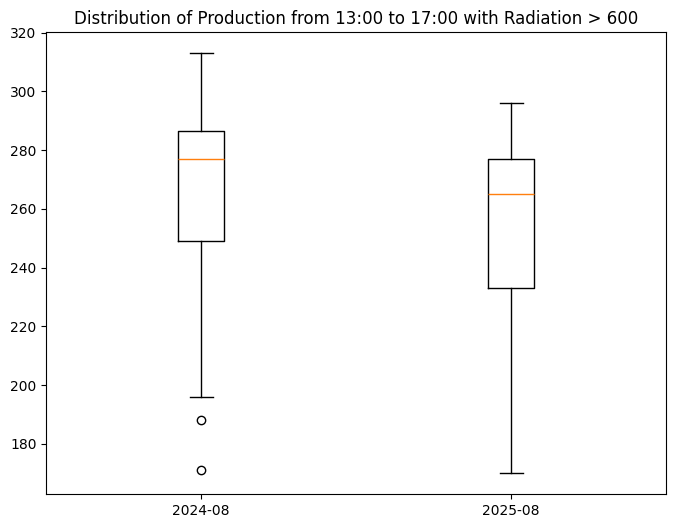

Number of rows for 2024-08 from 13:00 to 17:00: 68
Number of rows for 2025-08 from 13:00 to 17:00: 73


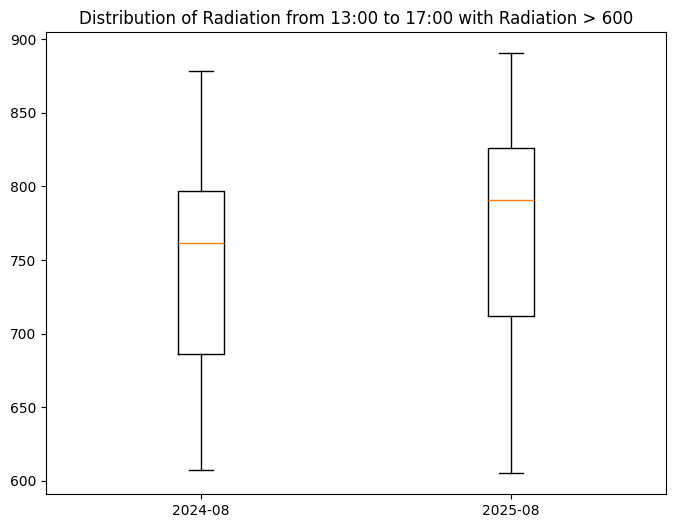

In [568]:
# for the year/month to be compared, we draw a boxplot of the distribution of Production for our selected time of the day for when radiation is significant

date_year_minus_1 = f"{year_y_minus_1}-{month_to_compare}"
date_year = f"{year_y}-{month_to_compare}"

df_year_minus_1 = df[
    (df['Date'].dt.strftime('%Y-%m') == date_year_minus_1 ) &
    (df['Time'].isin(time_range))
]

df_year = df[
    (df['Date'].dt.strftime('%Y-%m') == date_year) &
    (df['Time'].isin(time_range))
]
plt.figure(figsize=(8, 6))
data_to_plot = [df_year_minus_1['Production'], df_year['Production']]
plt.boxplot(data_to_plot, tick_labels=[date_year_minus_1, date_year])
plt.title(f'Distribution of Production {time_description} with Radiation > {min_radiation.__str__()}')
plt.show()

# print number of rows used
print(f"Number of rows for {date_year_minus_1} {time_description}: {len(df_year_minus_1)}")
print(f"Number of rows for {date_year} {time_description}: {len(df_year)}")

#at the right of this boxplot for production, draw a boxplot of the distribution of Radiation for our times for when radiation > min_radiation
plt.figure(figsize=(8, 6))
data_to_plot = [df_year_minus_1['Radiation'], df_year['Radiation']]
plt.boxplot(data_to_plot, tick_labels=[date_year_minus_1, date_year])
plt.title(f'Distribution of Radiation {time_description} with Radiation > {min_radiation.__str__()}')
plt.show()

In [569]:
# display a table with top ten radiations of 2024-08 at Hour 14:00, and the corresponding productions.
# and list top ten radiations of 2025-08 at selected time, and the corresponding productions in the same table.
number_of_top=15
df_year_minus_1 = df[
    (df['Date'].dt.strftime('%Y-%m') == f'{year_y_minus_1}-{month_to_compare}') &
    (df['Time'].isin(time_range))
]

df_year = df[
    (df['Date'].dt.strftime('%Y-%m') == f'{year_y}-{month_to_compare}') &
    (df['Time'].isin(time_range))
]

# Trier et sélectionner les top valeurs
df_year_minus_1_sorted = df_year_minus_1[['Radiation', 'Production']].sort_values(by='Radiation', ascending=False).head(number_of_top)
df_year_sorted = df_year[['Radiation', 'Production']].sort_values(by='Radiation', ascending=False).head(number_of_top)

# Combiner les deux tableaux
combined_df = pd.concat(
    [df_year_minus_1_sorted.reset_index(drop=True), df_year_sorted.reset_index(drop=True)],
    axis=1,
    keys=[f'{year_y_minus_1}-{month_to_compare}', f'{year_y}-{month_to_compare}']
)

# Affichage
print(f"Top {number_of_top} radiations and productions for {year_y_minus_1}-{month_to_compare} and {year_y}-{month_to_compare} {time_description} :")
display(combined_df.round(0).astype(int))


Top 15 radiations and productions for 2024-08 and 2025-08 from 13:00 to 17:00 :


2024-08              2025-08           
   Radiation Production Radiation Production
0        878        313       890        289
1        874        304       889        284
2        840        297       862        286
3        832        276       861        285
4        830        306       858        277
5        828        305       858        260
6        823        286       854        274
7        822        283       853        286
8        820        285       850        278
9        820        281       841        276
10       819        296       840        271
11       813        277       838        272
12       813        284       837        267
13       812        276       832        278
14       800        276       832        271

c:\Users\local\anaconda\envs\DST\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\local\anaconda\envs\DST\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


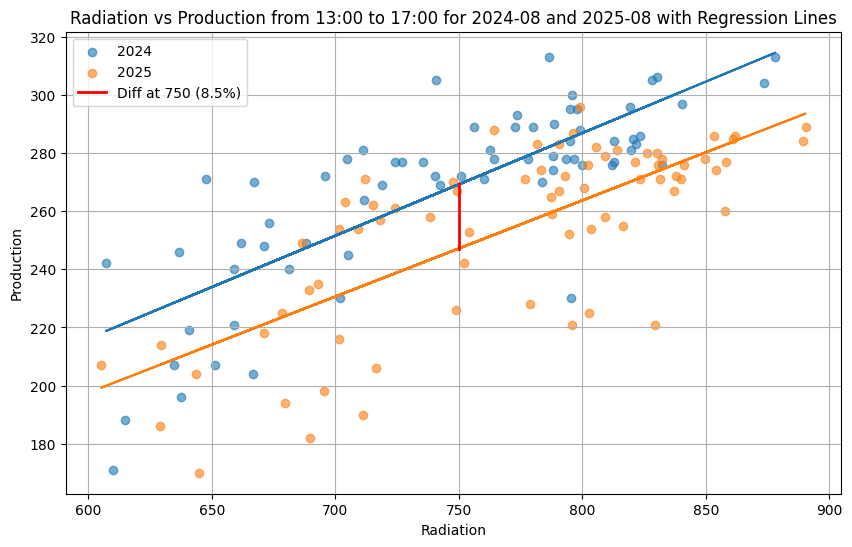

In [570]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# We'll compute and plot a regression line for each year for this month and the selected time range

# Initialize plot
plt.figure(figsize=(10, 6))

# Store predictions for Radiation = 750
predictions = {}

# Loop through each year
for year, df_year_to_predict in zip([year_y_minus_1, year_y], [df_year_minus_1, df_year]):
    # Scatter plot
    plt.scatter(df_year_to_predict['Radiation'], df_year_to_predict['Production'], label=year, alpha=0.6)

    # Fit regression model
    model_year = LinearRegression()
    X_year = df_year_to_predict[['Radiation']]
    model_year.fit(X_year, df_year_to_predict['Production'])

    # Predict full line
    y_year_pred = model_year.predict(X_year)
    plt.plot(X_year, y_year_pred)

    # Predict for Radiation = 750
    pred = model_year.predict([[750]])[0]
    predictions[year] = pred

# Calculate percentage difference
pred_year_minus_1 = predictions[year_y_minus_1]
pred_year = predictions[year_y]
percentage_diff = abs(pred_year - pred_year_minus_1) / ((pred_year_minus_1 + pred_year) / 2) * 100

# Plot red line between the two predictions
plt.plot([750, 750], [pred_year_minus_1, pred_year], color='red', linewidth=2, label=f'Diff at 750 ({percentage_diff:.1f}%)')

# Final touches
plt.xlabel('Radiation')
plt.ylabel('Production')
plt.title(f'Radiation vs Production {time_description} for {year_y_minus_1}-{month_to_compare} and {year_y}-{month_to_compare} with Regression Lines')
plt.legend()
plt.grid(True)
plt.show()

Obviously, August 2024 had better production for the less radiation than August 2024 !

We started the comparison for August ('08').
We want next September but we need to lower the threshold because there is less radiation in September.
Year, month... are parameters so we can change parameters and re-run until here.

beware: if we have to few rows we will not conclude anything.

SVR Mean Squared Error: 866.967253125491


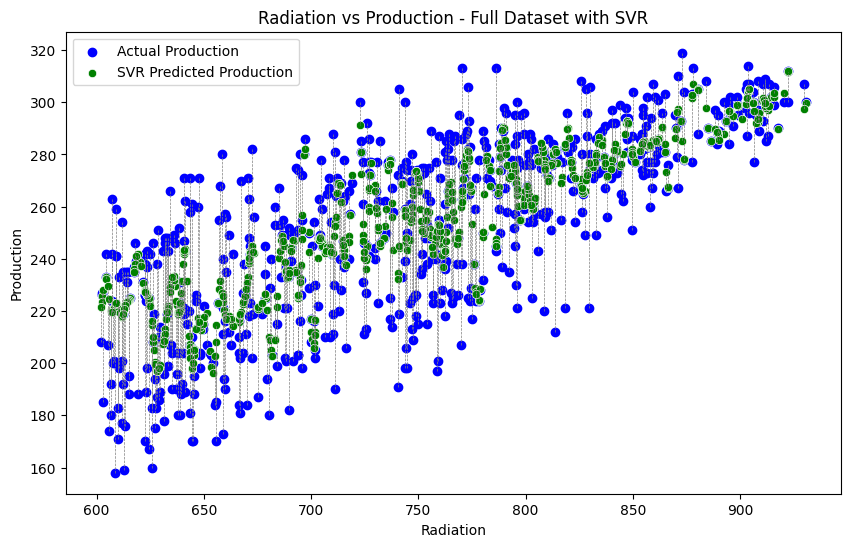

In [571]:
# let's try with SVR
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_model.fit(X_train, y_train)
y_svr_pred = svr_model.predict(X_test)
# evaluate the SVR model
svr_mse = mean_squared_error(y_test, y_svr_pred)
print(f"SVR Mean Squared Error: {svr_mse}")

# plot the predicted vs actual values for the whole dataset
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Production')
y_svr_full_pred = svr_model.predict(X)
sns.scatterplot(x=X.squeeze(), y=y_svr_full_pred, color='green', label='SVR Predicted Production')
plt.xlabel('Radiation')
plt.ylabel('Production')
plt.title('Radiation vs Production - Full Dataset with SVR')
plt.legend()

# now add a line between acutual and predicted dots
for i in range(len(X)):
    plt.plot([X.iloc[i, 0], X.iloc[i, 0]], [y.iloc[i], y_svr_full_pred[i]], color='gray', linestyle='--', linewidth=0.5)
plt.show()

***
suggestion: pour d'autres modèles, on pourrait ajouter le numéro du mois comme variable explicative supplémentaire.